# Credit Card Fraud Detection using Anomaly Detection

Predict fraud transactions using Isolation Forest Algorithm.

## 1. Import the libraries

Import the required libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.metrics import fbeta_score, roc_auc_score, roc_curve

## 2. Load the Dataset

Download the dataset from Kaggle.

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 3. Preprocess the Data

Normalise the **Amount** column and drop the **Time** column because it is irrevalent in fraud detection.

In [3]:
# Every column is normalised except 'Amount'
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])
data = data.drop('Time', axis=1)

## 4. Train - Test Split

Split the dataset in training (80%) and testing (20%).

In [4]:
x_data = data.drop('Class', axis=1)
y_data = data['Class']

y_data = np.where(y_data == 1, -1, 1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

## 5. Train the Model

**IsolationForest** is an unsupervised algorithm that isolates anomalies by randomly partitioning data.

* **contamination=0.0035**: Tells the model to expect a fraud rate of 0.35%.

In [6]:
# contamination = y_data.mean()

model = IsolationForest(contamination=0.0035)
model.fit(x_train)

IsolationForest(contamination=0.0035)

## 6. Make Predications

Make the predictions and map them to binary labels.

In [7]:
y_predicted = model.predict(x_test)

# Map predictions: anomaly -> 1 and normal -> 0
y_predicted = np.where(y_predicted == -1, 1, 0)
y_test = np.where(y_test == -1, 1, 0)

## 7. Evaluate the model

### a. Confusion Matrix

Shows True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN).

In [8]:
print(confusion_matrix(y_test, y_predicted))

[[56694   170]
 [   56    42]]


### b. Classification Report

Includes precision, recall, and F1-score.

* **Precision**: When the model says something is positive, how often is it actually correct?
$$
TP / (TP + FP)
$$

* **Recall**: How many of the actual positives did the model correctly find?
$$
TP / (TP + FN)
$$

* **F1-Score**: Can the model balance precision and recall, or is it sacrificing one for the other?
$$
2 * (Precision * Recall) / (Precision + Recall)
$$

* **Support**: How many real examples of each class are in the dataset?

In [9]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.20      0.43      0.27        98

    accuracy                           1.00     56962
   macro avg       0.60      0.71      0.63     56962
weighted avg       1.00      1.00      1.00     56962



### c. Number of Predictions of each class

Plot the number of predictions of each class made by the model.

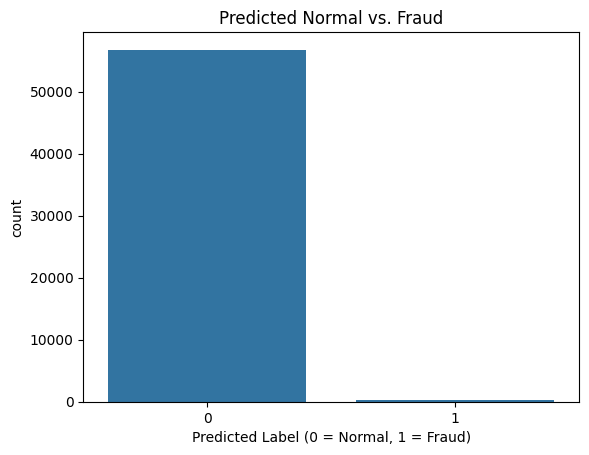

In [10]:
sns.countplot(x=y_predicted)
plt.title('Predicted Normal vs. Fraud')
plt.xlabel('Predicted Label (0 = Normal, 1 = Fraud)')
plt.show()

### d. Anomaly Scores

Lower values from **decision_function** indicate higher anomaly likelihood. We invert the sign for compatibilty with oher metrics.

In [11]:
scores = -model.decision_function(x_test)
print(f"Anomalous Scores: {scores}")

Anomalous Scores: [ 0.10506006 -0.18911773 -0.23801043 ... -0.1923398  -0.23715308
 -0.10746099]


### e. Average Precision Score

Summarizes the precision-recall curve, suitable for imbalanced data.

In [12]:
ap_score = average_precision_score(y_test, scores)
print(f"Average Precision Score: {ap_score}")

Average Precision Score: 0.20618257142324345


### f. Precision - Recall Curve

Shows the trade-off between precision and recall. High area under the curve (AP) indicates good performance.

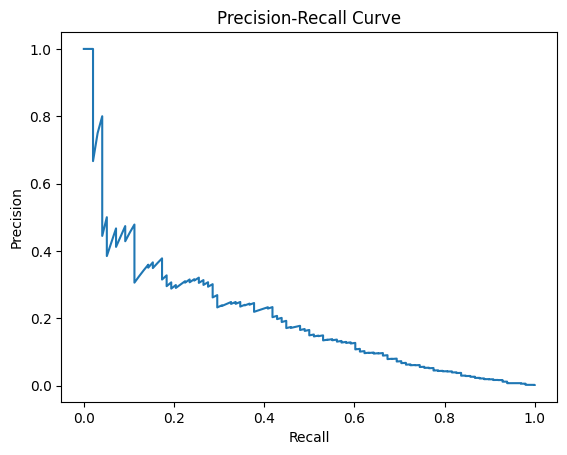

In [13]:
precision, recall, _ = precision_recall_curve(y_test, scores)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### g. F2-Score

Emphasizes recall over precision (weighted by beta=2), critical in fraud detection where missing fraud is costlier than false alerts.

In [ ]:
f2 = fbeta_score(y_test, y_predicted, beta=2)
print(f"F2-Score: {f2}")

F2-Score: 0.347682119205298


### h. ROC - AUC Score

Measures the model’s ability to distinguish between classes. Less informative than AP for imbalanced data but still useful.

In [15]:
roc_score = roc_auc_score(y_test, scores)
print(f"ROC Score: {roc_score}")

ROC Score: 0.9574817968830751


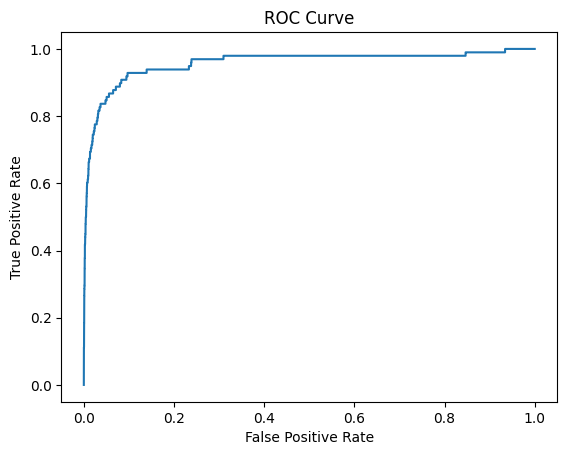

In [16]:
fpr, tpr, _ = roc_curve(y_test, scores)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()